In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
strDataTrain = '/content/drive/MyDrive/Colab Notebooks/RNN/train.csv'

In [5]:
df = pd.read_csv(strDataTrain)

In [6]:
df = df.reindex(columns=['date','sales','item','store'])

In [7]:
df.shape

(913000, 4)

In [8]:
df.head()

,date,sales,item,store
0,2013-01-01,13,1,1
1,2013-01-02,11,1,1
2,2013-01-03,14,1,1
3,2013-01-04,13,1,1
4,2013-01-05,10,1,1


In [17]:
!pip install pyramid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


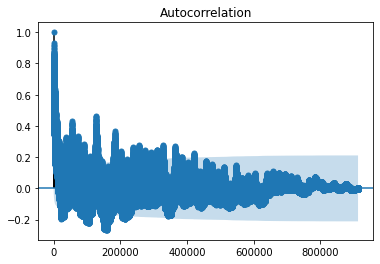

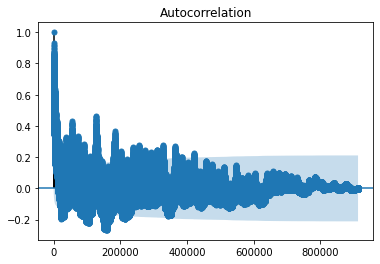

In [18]:
plot_acf(df['sales'], lags=912999)

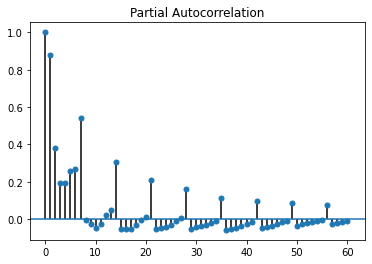

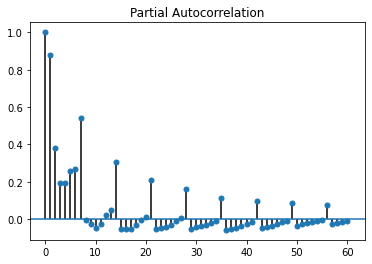

In [19]:
plot_pacf(df['sales'])

In [9]:
dataTrain =df.iloc[0:730400]
dataTest = df.iloc[730400:913000]

In [10]:
dataTest.shape, dataTrain.shape

((182600, 4), (730400, 4))

In [11]:
dataTrain.head()

,date,sales,item,store
0,2013-01-01,13,1,1
1,2013-01-02,11,1,1
2,2013-01-03,14,1,1
3,2013-01-04,13,1,1
4,2013-01-05,10,1,1


In [12]:
colsTrain =list(dataTrain)[1:4]
colsTrain

['sales', 'item', 'store']

In [13]:
dataTrain_cols = dataTrain[colsTrain].astype(float)
dataTrain_cols

,sales,item,store
0,13.0,1.0,1.0
1,11.0,1.0,1.0
2,14.0,1.0,1.0
3,13.0,1.0,1.0
4,10.0,1.0,1.0
...,...,...,...
730395,34.0,40.0,10.0
730396,30.0,40.0,10.0
730397,33.0,40.0,10.0
730398,29.0,40.0,10.0


In [14]:
dataTrain_cols.shape

(730400, 3)

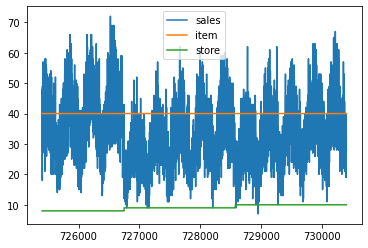

In [15]:
df_for_plot = dataTrain_cols.tail(5000)
df_for_plot.plot.line()

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
dataTrain_scaled = scaler.fit_transform(dataTrain_cols)
dataTrain_scaled

array([[0.05627706, 0.        , 0.        ],
       [0.04761905, 0.        , 0.        ],
       [0.06060606, 0.        , 0.        ],
       ...,
       [0.14285714, 1.        , 1.        ],
       [0.12554113, 1.        , 1.        ],
       [0.12121212, 1.        , 1.        ]])

In [18]:
dataTrain_scaled.shape

(730400, 3)

In [19]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = dataTrain_scaled.shape[0]
ventana = 30
for i in range(ventana, cantidad-ventana+1):
  X_train.append(dataTrain_scaled[i - ventana: i, 0:dataTrain_cols.shape[1]])
  Y_train.append(dataTrain_scaled[i + ventana-1:i +ventana, 0])

In [20]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
print('trainX shape == {}.',format(X_train.shape))
print('trainY shape == {}.',format(Y_train.shape))

trainX shape == {}. (730341, 30, 3)
trainY shape == {}. (730341, 1)


In [21]:
forecaster = Sequential()

#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1],X_train.shape[2]), units=10, return_sequences=True))
#forecaster.add(LSTM(input_shape=(ventana,X_train.shape[1]-1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=15, return_sequences=True))

#capa3
forecaster.add(LSTM(units=18, return_sequences=True))

#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=10, return_sequences=False))

#capa de salida
forecaster.add(Dense(Y_train.shape[1], activation='relu'))

In [22]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')
forecaster.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 10)            560       
                                                                 
 lstm_1 (LSTM)               (None, 30, 15)            1560      
                                                                 
 lstm_2 (LSTM)               (None, 30, 18)            2448      
                                                                 
 lstm_3 (LSTM)               (None, 10)                1160      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 5,739
Trainable params: 5,739
Non-trainable params: 0
_________________________________________________________________


In [23]:
#parametros de entrenamiento
forecaster.fit(X_train, Y_train, epochs=2, batch_size=32)

Epoch 1/2
22824/22824 [==============================] - 1042s 45ms/step - loss: 0.0031
Epoch 2/2
22824/22824 [==============================] - 1031s 45ms/step - loss: 0.0026


In [24]:
forecaster.save('/content/drive/MyDrive/Colab Notebooks/RNN/RNN_LB3.h5')

In [25]:
colsTest =list(dataTest)[1:6]
dataTest_cols = dataTest[colsTest].astype(float)

In [26]:
dataTest_cols

,sales,item,store
730400,6.0,41.0,1.0
730401,15.0,41.0,1.0
730402,5.0,41.0,1.0
730403,9.0,41.0,1.0
730404,13.0,41.0,1.0
...,...,...,...
912995,63.0,50.0,10.0
912996,59.0,50.0,10.0
912997,74.0,50.0,10.0
912998,62.0,50.0,10.0


In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
dataTest_scaled = scaler.fit_transform(dataTest_cols)
dataTest_scaled

array([[0.01970443, 0.        , 0.        ],
       [0.06403941, 0.        , 0.        ],
       [0.01477833, 0.        , 0.        ],
       ...,
       [0.3546798 , 1.        , 1.        ],
       [0.2955665 , 1.        , 1.        ],
       [0.39408867, 1.        , 1.        ]])

In [28]:
dataset_total = pd.concat((dataTrain_cols, dataTest_cols), axis=0)
dataset_total

,sales,item,store
0,13.0,1.0,1.0
1,11.0,1.0,1.0
2,14.0,1.0,1.0
3,13.0,1.0,1.0
4,10.0,1.0,1.0
...,...,...,...
912995,63.0,50.0,10.0
912996,59.0,50.0,10.0
912997,74.0,50.0,10.0
912998,62.0,50.0,10.0


In [29]:
input_test = dataset_total[len(dataset_total) - len(dataTest) - ventana : ].values
input_test.shape
scaler = MinMaxScaler(feature_range=(0,1))
input_test = scaler.fit_transform(input_test)
input_test

array([[0.11330049, 0.        , 1.        ],
       [0.18719212, 0.        , 1.        ],
       [0.09359606, 0.        , 1.        ],
       ...,
       [0.3546798 , 1.        , 1.        ],
       [0.2955665 , 1.        , 1.        ],
       [0.39408867, 1.        , 1.        ]])

In [30]:
input_test.shape

(182630, 3)

In [31]:
cantidad_final = len(input_test)
cantidad_final

182630

In [32]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0:dataTest_cols.shape[1]])

X_test = np.array(X_test)

In [33]:
predicciones_rnn = forecaster.predict(X_test)
predicciones_rnn

array([[0.13354465],
       [0.12799098],
       [0.12380895],
       ...,
       [0.3221379 ],
       [0.34888098],
       [0.2417693 ]], dtype=float32)

In [34]:
forecaster_copies = np.repeat(predicciones_rnn,dataTrain_cols.shape[1],axis=-1)
real_predicted_sales = scaler.inverse_transform(forecaster_copies)[:,0]
real_predicted_sales

array([29.109564, 27.982168, 27.133217, ..., 67.394   , 72.82284 ,
       51.079166], dtype=float32)

In [35]:
real_test_sales = dataTest.iloc[:, 1:2].values
real_test_sales

array([[ 6],
       [15],
       [ 5],
       ...,
       [74],
       [62],
       [82]])

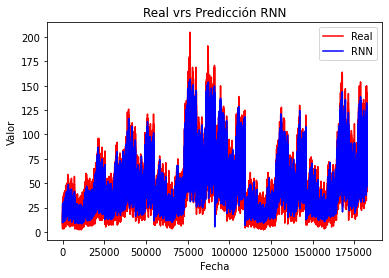

In [36]:
plt.plot(real_test_sales, color="red", label="Real")
plt.plot(real_predicted_sales, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

In [ ]:
def smape ( a , f ):
     return 1 / len (a) * np. sum (2 * np. abs (a) / (np. abs (a) + np. abs (f)) * 100)

In [ ]:
#smape(real_test_price,real_predicted_price)

In [ ]:
!pip install sktime[all_extras]

In [ ]:
#from sktime.performance_metrics.forecasting import smape_loss